# 01 — Exploratory Data Analysis (Reliance Industries)

**Objectives:** Load Reliance stock data, add features (technical indicators, calendar), define target (log return at t+1), and prepare train/val/test splits.

**Evaluation Metrics:** MAE (magnitude), directional accuracy (direction).

**Key Constraints:** Time-ordered splits only, fit scalers on train, no lookahead leakage.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator, MACD
from ta.volatility import BollingerBands

SYMBOL = "RELIANCE"
DATA_FILENAME = "RELI Historical Data.csv"

# Find CSV file
project_root = Path(os.getcwd())
if project_root.name == 'notebooks':
    csv_path = project_root / DATA_FILENAME
    if not csv_path.exists():
        csv_path = project_root.parent / DATA_FILENAME
else:
    csv_path = project_root / DATA_FILENAME
    if not csv_path.exists():
        csv_path = project_root / 'notebooks' / DATA_FILENAME

print(f"Using data file: {csv_path}")

Using data file: /Users/bhavishya/VSC Projects/stock-price-prediction/notebooks/RELI Historical Data.csv


## Helper Functions

All feature engineering and utility functions defined here (no external imports).

In [2]:
def parse_volume(vol_str):
    """Parse volume strings like '8.96M' to numeric values."""
    if pd.isna(vol_str) or vol_str == '-':
        return 0.0
    vol_str = str(vol_str).strip()
    if vol_str.endswith('M'):
        return float(vol_str[:-1].replace(',', '')) * 1_000_000
    elif vol_str.endswith('K'):
        return float(vol_str[:-1].replace(',', '')) * 1_000
    elif vol_str.endswith('B'):
        return float(vol_str[:-1].replace(',', '')) * 1_000_000_000
    else:
        try:
            return float(vol_str.replace(',', ''))
        except:
            return 0.0

def parse_price(price_str):
    """Parse price strings like '1,567.50' to float."""
    if pd.isna(price_str) or price_str == '-':
        return np.nan
    return float(str(price_str).replace(',', ''))

def add_technical_indicators(df):
    """Add RSI, MACD, EMAs, Bollinger Bands."""
    out = df.copy()
    out['rsi'] = RSIIndicator(close=out['close'].squeeze(), window=14).rsi()
    macd = MACD(close=out['close'].squeeze())
    out['macd'] = macd.macd()
    out['ema_10'] = EMAIndicator(close=out['close'].squeeze(), window=10).ema_indicator()
    out['ema_20'] = EMAIndicator(close=out['close'].squeeze(), window=20).ema_indicator()
    bb = BollingerBands(close=out['close'].squeeze(), window=20, window_dev=2)
    out['bb_high'] = bb.bollinger_hband()
    out['bb_low'] = bb.bollinger_lband()
    return out

def add_calendar(df):
    """Add day-of-week, day-of-month, is_month_end."""
    out = df.copy()
    out['dow'] = out.index.dayofweek
    out['dom'] = out.index.day
    out['is_month_end'] = out.index.is_month_end.astype(int)
    return out

def build_target(df):
    """Build next-step log-return target y."""
    out = df.copy()
    price = out['close']
    out['y'] = (np.log(price) - np.log(price.shift(1))).shift(-1)
    return out

def time_split(df, train_end, val_end):
    """Split DataFrame by date into train/val/test."""
    train_end_dt = pd.to_datetime(train_end)
    val_end_dt = pd.to_datetime(val_end)
    train = df[df.index <= train_end_dt]
    val = df[(df.index > train_end_dt) & (df.index <= val_end_dt)]
    test = df[df.index > val_end_dt]
    return train, val, test

## Load Data

Load Reliance CSV with custom parsing for prices and volumes.

In [3]:
# Load CSV
raw_df = pd.read_csv(csv_path)
raw_df.columns = [col.strip() for col in raw_df.columns]
print(f"Raw columns: {list(raw_df.columns)}")

# Parse prices (remove commas)
for col in ['Price', 'Open', 'High', 'Low']:
    raw_df[col] = raw_df[col].apply(parse_price)

# Parse volume (e.g., "8.96M")
raw_df['Vol.'] = raw_df['Vol.'].apply(parse_volume)

# Rename to standard OHLCV format
raw_df = raw_df.rename(columns={
    'Date': 'date',
    'Price': 'close',  # Price column is the closing price
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Vol.': 'volume',
})

# Parse dates (format: DD-MM-YYYY like "28-11-2025")
raw_df['date'] = pd.to_datetime(raw_df['date'], format='%d-%m-%Y')
raw_df = raw_df.sort_values('date').set_index('date')

# Keep only OHLCV columns
df = raw_df[['open', 'high', 'low', 'close', 'volume']].copy()

print(f"\nData shape: {df.shape}")
print(f"Date range: {df.index.min()} to {df.index.max()}")
df.head()

Raw columns: ['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']

Data shape: (250, 5)
Date range: 2024-11-28 00:00:00 to 2025-11-28 00:00:00


,open,high,low,close,volume
date,,,,,
2024-11-28,1289.95,1296.60,1269.05,1270.80,15030000.0
2024-11-29,1280.00,1299.50,1275.25,1292.20,13200000.0
2024-12-02,1288.00,1311.35,1277.05,1309.15,11020000.0
2024-12-03,1317.00,1326.80,1307.00,1323.30,16870000.0
2024-12-04,1326.00,1328.40,1304.05,1308.95,19610000.0


In [4]:
# Basic statistics
print("Basic statistics:")
df.describe()

Basic statistics:


,open,high,low,close,volume
count,250.000000,250.000000,250.000000,250.000000,2.500000e+02
mean,1359.893400,1371.289800,1349.221200,1360.218800,1.176296e+07
std,103.206123,102.806883,103.633571,103.173818,4.952643e+06
min,1132.200000,1171.250000,1114.850000,1161.900000,2.070000e+06
25%,1260.300000,1271.537500,1245.400000,1263.087500,8.185000e+06
50%,1381.200000,1389.000000,1370.050000,1378.150000,1.045000e+07
75%,1430.775000,1442.700000,1423.475000,1431.275000,1.411750e+07
max,1575.000000,1581.300000,1563.000000,1569.900000,3.254000e+07


## Add Features and Target

In [5]:
# Add technical indicators
df = add_technical_indicators(df)
print(f"After technical indicators: {list(df.columns)}")

# Add calendar features
df = add_calendar(df)
print(f"After calendar features: {list(df.columns)}")

# Build target (next-step log return)
df = build_target(df)
print(f"After target: {list(df.columns)}")

# Drop rows with NaN
df = df.dropna()
print(f"\nFinal shape: {df.shape}")
df.tail()

After technical indicators: ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema_10', 'ema_20', 'bb_high', 'bb_low']
After calendar features: ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema_10', 'ema_20', 'bb_high', 'bb_low', 'dow', 'dom', 'is_month_end']
After target: ['open', 'high', 'low', 'close', 'volume', 'rsi', 'macd', 'ema_10', 'ema_20', 'bb_high', 'bb_low', 'dow', 'dom', 'is_month_end', 'y']

Final shape: (224, 15)


,open,high,low,close,volume,rsi,macd,ema_10,ema_20,bb_high,bb_low,dow,dom,is_month_end,y
date,,,,,,,,,,,,,,,
2025-11-21,1541.0,1557.8,1540.1,1546.6,9620000.0,73.867021,29.211326,1520.017950,1497.465300,1547.337266,1453.652734,4,21,0,-0.006942
2025-11-24,1550.0,1550.0,1531.8,1535.9,18430000.0,68.267754,28.694533,1522.905596,1501.125748,1548.249541,1461.170459,0,24,0,0.002471
2025-11-25,1535.9,1559.6,1525.1,1539.7,15030000.0,69.161788,28.265769,1525.959124,1504.799486,1552.486484,1462.493516,1,25,0,0.019424
2025-11-26,1542.3,1571.6,1540.5,1569.9,14050000.0,75.153231,30.016842,1533.948374,1510.999535,1563.118205,1460.161795,2,26,0,-0.004149
2025-11-27,1575.0,1575.5,1556.0,1563.4,9790000.0,71.914679,30.528175,1539.303215,1515.990056,1570.633097,1458.566903,3,27,0,0.002619


## Visualizations

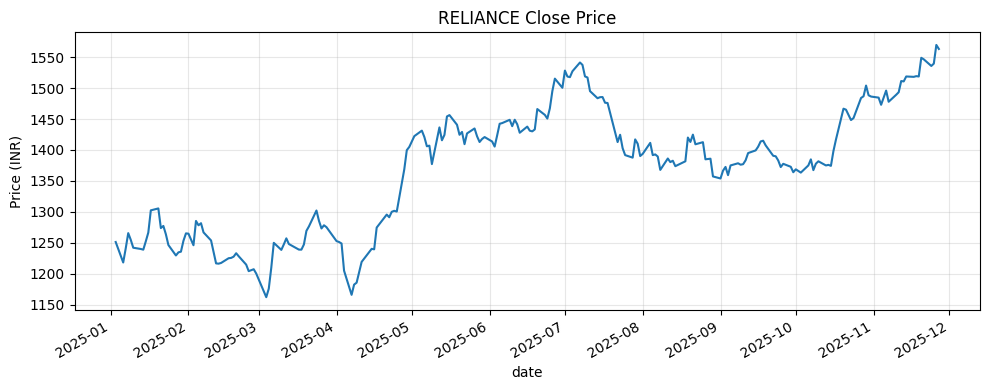

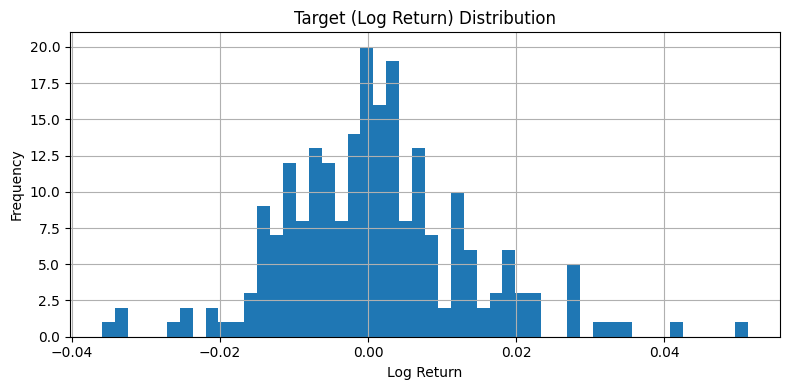

In [6]:
# Plot close price
fig, ax = plt.subplots(figsize=(10, 4))
df['close'].plot(ax=ax, title=f"{SYMBOL} Close Price")
ax.set_ylabel("Price (INR)")
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Plot target distribution
fig, ax = plt.subplots(figsize=(8, 4))
df['y'].hist(bins=50, ax=ax)
ax.set_title("Target (Log Return) Distribution")
ax.set_xlabel("Log Return")
ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

## Time-Aware Split

In [7]:
# 60/20/20 chronological split
n_samples = len(df)
train_end_idx = int(n_samples * 0.6)
val_end_idx = int(n_samples * 0.8)

train_end_date = df.index[train_end_idx - 1]
val_end_date = df.index[val_end_idx - 1]

train, val, test = time_split(df, str(train_end_date.date()), str(val_end_date.date()))

print(f"Train: {len(train)} samples ({train.index.min().date()} to {train.index.max().date()})")
print(f"Val: {len(val)} samples ({val.index.min().date()} to {val.index.max().date()})")
print(f"Test: {len(test)} samples ({test.index.min().date()} to {test.index.max().date()})")

Train: 134 samples (2025-01-03 to 2025-07-17)
Val: 45 samples (2025-07-18 to 2025-09-22)
Test: 45 samples (2025-09-23 to 2025-11-27)


In [8]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())

print("\nTarget statistics:")
print(df['y'].describe())

Missing values per column:
open            0
high            0
low             0
close           0
volume          0
rsi             0
macd            0
ema_10          0
ema_20          0
bb_high         0
bb_low          0
dow             0
dom             0
is_month_end    0
y               0
dtype: int64

Target statistics:
count    224.000000
mean       0.001006
std        0.012645
min       -0.035872
25%       -0.006991
50%        0.000618
75%        0.007117
max        0.051263
Name: y, dtype: float64
